In [1]:
import os
import glob

train_images_link = glob.glob('C:\\Users\\sanda\\Desktop\\dacon\\train_imgs' + '\\*.'+ 'png')

In [2]:
from PIL import Image

size_list = []
size_x_list = []
size_y_list = []

for t_image in train_images_link:
    image = Image.open(t_image)
    size_list.append(image.size)
    size_x_list.append(image.size[0])
    size_y_list.append(image.size[1])

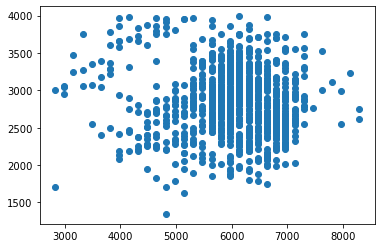

In [3]:
import matplotlib.pyplot as plt

plt.scatter(size_x_list,size_y_list)

In [4]:
test_images_link = glob.glob('C:\\Users\\sanda\\Desktop\\dacon\\test_imgs' + '\\*.'+ 'png')

In [5]:
from PIL import Image

test_size_list = []
test_size_x_list = []
test_size_y_list = []

for t_image in test_images_link:
    image = Image.open(t_image)
    test_size_list.append(image.size)
    test_size_x_list.append(image.size[0])
    test_size_y_list.append(image.size[1])

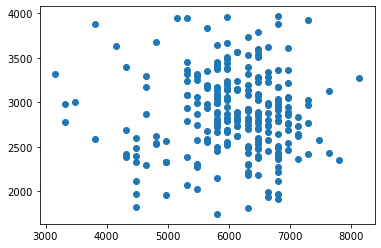

In [6]:
plt.scatter(test_size_x_list,test_size_y_list)

In [7]:
mean_train_x = sum(size_x_list) // len(size_x_list)
mean_train_y = sum(size_y_list) // len(size_y_list)
mean_test_x = sum(test_size_x_list) // len(test_size_x_list)
mean_test_y = sum(test_size_y_list) // len(test_size_y_list)

train_row = mean_train_x // 224
train_col = mean_train_y // 224

test_row = mean_test_x // 224
test_col = mean_test_y // 224

print(mean_train_x,mean_train_y ,mean_test_x ,mean_test_y )
print(train_row, train_col , train_row * train_col)
print(test_row , test_col , test_row * test_col)

6003 2850 6062 2873
26 12 312
27 12 324


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 31 19:51:35 2022

@author: jsyoon
"""

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import cv2
import os
# from spectral import *
#%% opening
def bwareaopen(img, min_size, connectivity=8):
        """Remove small objects from binary image (approximation of
        bwareaopen in Matlab for 2D images).
   
        Args:
            img: a binary image (dtype=uint8) to remove small objects from
            min_size: minimum size (in pixels) for an object to remain in the image
            connectivity: Pixel connectivity; either 4 (connected via edges) or 8 (connected via edges and corners).
   
        Returns:
            the binary image with small objects removed
        """
   
        # Find all connected components (called here "labels")
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            img, connectivity=connectivity)
       
        # check size of all connected components (area in pixels)
        for i in range(num_labels):
            label_size = stats[i, cv2.CC_STAT_AREA]
           
            # remove connected components smaller than min_size
            if label_size < min_size:
                img[labels == i] = 0
               
        return img
#%% tiling
def window_nd(a, window, steps = None):
    ashp = np.array(a.shape)

    wshp = np.array(window).reshape(-1)

    if steps:
        stp = np.array(steps).reshape(-1)
    else:
        stp = np.ones_like(ashp)

    astr = np.array(a.strides)
    assert np.all(np.r_[ashp.size == wshp.size, wshp.size == stp.size, wshp <= ashp])
    shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
    strides = tuple(astr * stp) + tuple(astr)
    as_strided = np.lib.stride_tricks.as_strided
    aview = as_strided(a, shape = shape, strides = strides)
    #aview = cv2.cvtColor(aview,cv2.COLOR_GRAY2RGB)
    #print(aview.shape)
    return aview

In [9]:
k = 8 * 6 
k

48

In [12]:
#%%
# path_p = 'train_imgs'
# path_p = 'test_imgs'

for path_p in ['C:\\Users\\sanda\\Desktop\\dacon\\train_imgs_HnE','C:\\Users\\sanda\\Desktop\\dacon\\test_imgs_HnE']:
    save_path = path_p+'_vector'
    #%%
    data_list = sorted(glob.glob(path_p+'/*.png'))
    dnum = len(data_list)
    #print(data_list)
    patch_size = 224
   
    for data_info in tqdm(data_list,desc= 'Current:'+path_p):
    # data_info = data_list[9]
        #print(data_info)
        file_name_full = data_info.split('\\')[-1]
        #print(file_name_full)
        file_name, _ = file_name_full.split('.')
        #print(file_name)
        #w, h  = patch_size*16,patch_size*8 
        w, h  = patch_size*8,patch_size*6 # 하이퍼 파라미터
        img = cv2.imread(data_info)
        img = cv2.resize(img, (w, h))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
           
        # img_patch = np.reshape(img_g, (patch_size,15,patch_size,7))
        # img_patch = np.transpose(img_patch,(0,2,1,3))
        # img_patch = np.reshape(img_patch, (patch_size,patch_size,15*7))
        # imshow(img_patch)
           
        #%%
        #img_t = window_nd(img_g, (224, 224), (224, 224))
        img_t = window_nd(img_g, (224, 224), (224, 224)) # fixed to color
        img_t = img_t.copy().reshape(-1, 224, 224) #to match expected output
        img_t = np.transpose(img_t,(2,1,0))
        cnum = np.size(img_t,2)
        bw_s=[]
        for idx in range(cnum):
            img_i = img_t[:,:,idx]
            # bw_i = cv2.adaptiveThreshold(img_i,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)
            # bw_i = 255-bw_i
            bw_i = cv2.GaussianBlur(img_t[:,:,idx], (0, 0), 2)<220        
            bw_i = bwareaopen(np.uint8(bw_i*255),20)
            bw_i = bw_i>250
            bw_s.append(bw_i.sum())
        #%%
        sort_index = np.argsort(bw_s)
        sort_index = sort_index[::-1]
        # plt.plot(np.array(bw_s)[sort_index])
        img_t_new = img_t[:,:,sort_index]
        img_t_new = img_t_new[:,:,:k] # 하이퍼 파라미터
        
        sort_index = np.argsort(bw_s)
        sort_index = sort_index[::-1]
        # plt.plot(np.array(bw_s)[sort_index])
        img_t_new = img_t[:,:,sort_index]    # fixed
        img_t_new = img_t
        #img_t_new = cv2.cvtColor(img_t_new,cv2.COLOR_GRAY2RGB)
        #print(type(img_t_new))
        img_t_new = img_t_new[:,:,:k] # 하이퍼 파라미터
        # imshow(z_new)
    
        # imshow(z_new)
        os.makedirs(save_path, exist_ok=True)
        save_name = save_path+'/'+file_name+'.npy'
        np.save(save_name, img_t_new) # save .npy

Current:C:\Users\sanda\Desktop\dacon\train_imgs_HnE:   1%|▎                          | 12/1000 [00:02<03:05,  5.34it/s]


KeyboardInterrupt: 

(224, 224, 48)


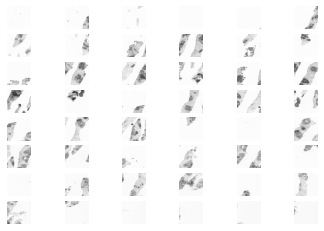

In [16]:
loaded_test_img = np.load('C:\\Users\\sanda\\Desktop\\dacon\\train_imgs_HnE_vector\\BC_01_0003.npy')

print(loaded_test_img.shape)

for i in range(k):
    #img = Image.fromarray(loaded_test_img[:,:,i])
    img = loaded_test_img[:,:,i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(8,6,i+1)
    plt.axis('off')
    plt.imshow(img)


In [ ]:
# https://youtu.be/tNfcvgPKgyU

# Original video on H&E topic: https://youtu.be/yUrwEYgZUsA
"""
This code normalizes staining appearance of H&E stained images.
It also separates the hematoxylin and eosing stains in to different images. 

Workflow based on the following papers:
A method for normalizing histology slides for quantitative analysis. 
M. Macenko et al., ISBI 2009
    http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf

Efficient nucleus detector in histopathology images. J.P. Vink et al., J Microscopy, 2013

Original MATLAB code:
    https://github.com/mitkovetta/staining-normalization/blob/master/normalizeStaining.m
 
Other useful references:
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5226799/
    https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169875

PROPOSED WORKFLOW:  
    
Input: RGB image
Step 1: Convert RGB to OD (optical density)
Step 2: Remove data with OD intensity less than β
Step 3: Calculate  singular value decomposition (SVD) on the OD tuples
Step 4: Create plane from the SVD directions corresponding to the
two largest singular values
Step 5: Project data onto the plane, and normalize to unit length
Step 6: Calculate angle of each point wrt the first SVD direction
Step 7: Find robust extremes (αth and (100−α)th 7 percentiles) of the
angle
Step 8: Convert extreme values back to OD space

Output: Optimal Stain Vectors

"""

import numpy as np
import cv2
from matplotlib import pyplot as plt

############### INPUT RGB IMAGE #######################
#Using opencv to read images may bemore robust compared to using skimage
#but need to remember to convert BGR to RGB.
#Also, convert to float later on and normalize to between 0 and 1.

#Image downloaded from:
#https://pbs.twimg.com/media/C1MkrgQWQAASbdz.jpg
# img=cv2.imread('images/HnE_Image.jpg', 1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
# alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
# beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


def norm_HnE(img, Io=240, alpha=1, beta=0.15):


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])
    
    
    # extract the height, width and num of channels of image
    h, w, c = img.shape
    
    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))
    
    # calculate optical density
    # OD = −log10(I)  
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero. 
    
    OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
    
    
    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()
    
    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    
    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product
    
    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 
    
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # Separating H and E components
    
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return (Inorm, H, E)

# img=cv2.imread('images/HnE_Image.jpg', 1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# norm_img, H_img, E_img = norm_HnE(img, Io=240, alpha=1, beta=0.15)


# plt.imsave("images/HnE_normalized.jpg", Inorm)
# plt.imsave("images/HnE_separated_H.jpg", H)
# plt.imsave("images/HnE_separated_E.jpg", E)

In [ ]:
img = cv2.imread('C:/Users/sanda/Desktop/dacon/train_imgs/BC_01_0015.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
Norm_img ,H_img, E_img = norm_HnE(img, Io=240, alpha=1, beta=0.15)

In [ ]:
plt.imshow(Norm_img)

In [ ]:
plt.imshow(H_img)

In [ ]:
plt.imshow(E_img)

In [ ]:
#%%
# path_p = 'train_imgs'
# path_p = 'test_imgs'

for path_p in ['C:\\Users\\sanda\\Desktop\\dacon\\train_imgs','C:\\Users\\sanda\\Desktop\\dacon\\test_imgs']:
    save_path = path_p+'_HnE'
    #%%
    data_list = sorted(glob.glob(path_p+'/*.png'))
    dnum = len(data_list)
    #print(data_list)
    patch_size = 224
   
    for data_info in tqdm(data_list,desc= 'Current:'+path_p):
        #print(data_info)
        file_name_full = data_info.split('\\')[-1]
        #print(file_name_full)
        file_name, _ = file_name_full.split('.')
        w, h  = patch_size*26,patch_size*12 # 하이퍼 파라미터
        img = cv2.imread(data_info)
        img = cv2.resize(img, (w, h))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
        Norm_img ,H_img, E_img = norm_HnE(img, Io=240, alpha=1, beta=0.15)   
 
        os.makedirs(save_path, exist_ok=True)
        save_name = save_path+'/'+file_name+'.png'
        #np.save(save_name, Norm_img) # save .npy
        plt.imsave(save_path+'/'+file_name+'.png', Norm_img)

In [40]:
import sys
import cv2
import glob
from matplotlib import pyplot as plt

train_path = 'C:\\Users\\sanda\\Desktop\\dacon\\train_imgs'
path_p = 'C:\\Users\\sanda\\Desktop\\dacon\\train_masks'

data_list = glob.glob(path_p+'\\*.png')

#print(data_list)

for data in data_list:
    file_name = data.split('\\')[-1]
    
    src = cv2.imread(train_path + '\\' + file_name, cv2.IMREAD_COLOR)
    mask = cv2.imread(data, cv2.IMREAD_COLOR)

    new_img = cv2.bitwise_or(src, mask)
    
    plt.imsave('C:\\Users\\sanda\\Desktop\\dacon\\masked_img\\'+ file_name + '.png', new_img)
    
# 마스크 영상을 이용한 영상 합성
# src = cv2.imread('C:\\Users\\sanda\\Desktop\\dacon\\train_imgs\\BC_01_0397.png', cv2.IMREAD_COLOR)
# mask = cv2.imread('C:\\Users\\sanda\\Desktop\\dacon\\train_masks\\BC_01_0397.png', cv2.IMREAD_COLOR)
# #dst = cv2.imread('field.bmp', cv2.IMREAD_COLOR)

# #src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
# #plt.imshow(src)

# #new_img  = cv2.copyTo(src, mask)
# new_img = cv2.bitwise_or(src, mask)

# plt.imshow(new_img)
# plt.imsave('C:\\Users\\sanda\\Desktop\\dacon\\mask.png', new_img)

#cv2.imshow('src', src)
#cv2.imshow('dst', dst)
#cv2.imshow('mask', mask)
#cv2.waitKey()
#cv2.destroyAllWindows()